# Clasificacion de documentos con word2vec
Antonio Murillo Sevillano y Ruben Romero Sanchez

El objetivo de este proyecto es utilizar técnicas de aprendizaje supervisado o no supervisado para clasificar fragmentos de 
texto en función de su temática, empleando una vectorización numérica de la información de los textos. 
Para ello usaremos un corpus compuesto por articulos periodisticos deportivos de el periodico ingles BBC. Dicho corpus contiene 
737 articulos relacionados con diferentes disciplinas deportivas clasificadas con las etiquetas athletics, cricket, football, 
rugby, tennis. 

Indice: 
 - Construcción del corpus de entrenamiento 
 - Tokenización del texto y eliminación de stopWords
 - Aplicación Steaming sobre el corpus
 - Word2vec
 - Clustering

## Construcción del corpus


In [2]:
import os
import csv

# Directorio raíz donde se encuentran las carpetas por categoría
root_directory = "./bbcsport"

# Nombre del archivo .csv de salida
csv_file = "./article.csv"

# Lista para almacenar las filas del archivo .csv
csv_rows = []

# Número por el que comenzarán los id
id = 0

# Recorre todas las carpetas en el directorio raíz
for label in os.listdir(root_directory):
    # Obtiene la ruta completa de la carpeta de la categoría
    label_folder  = os.path.join(root_directory, label)
    
    # Verifica que sea una carpeta
    if os.path.isdir(label_folder):
        # Recorre todos los archivos .txt en la carpeta de la categoría
        for txt_file  in os.listdir(label_folder):
            # Obtiene la ruta completa del archivo .txt
            txt_file_path  = os.path.join(label_folder, txt_file)
            
            # Lee el contenido del archivo .txt
            with open(txt_file_path, 'r') as file:
                content  = file.read().replace(".\n\n", ". ").replace("\n\n", ". ").replace("\n", "")
                
                # Agrega una nueva fila al archivo .csv
                row = [id, label, content]
                csv_rows.append(row)
                id += 1

# Escribe las filas en el archivo .csv
with open(csv_file, 'w', newline='') as file:
    csv_writer  = csv.writer(file, delimiter=';')
    csv_writer.writerow(['id', 'label', 'content'])
    csv_writer.writerows(csv_rows)

print("CSV creado")

CSV creado


Algunos datos sobre el csv que hemos generado y sobre el corpus: 

In [3]:
import pandas as pd

df = pd.read_csv("article.csv", sep=';')

print(df['label'].value_counts())
print("Número total de filas:", df.shape[0])

label
football     265
rugby        147
cricket      124
athletics    101
tennis       100
Name: count, dtype: int64
Número total de filas: 737


Algunas filas del archivo generado serían estas:

In [4]:
import random

random_index = random.sample(range(0, df.shape[0]), 5)
df.iloc[random_index]

,id,label,content
693,693,tennis,Moya suffers shock loss. Fifth seed Carlos Moy...
528,528,rugby,"Scotland v Italy (Sat). Murrayfield, Edinburgh..."
181,181,cricket,"Lee runs through Windies. VB Series match 6, A..."
87,87,athletics,Jones files lawsuit against Conte. Marion Jone...
288,288,football,Stam spices up Man Utd encounter. AC Milan def...


## Tokenización del texto y eliminación de StopWords

In [5]:
from nltk.corpus import stopwords
import re

def tokenizacion_y_stopWords(text):
    # Todo lo que no sean letras lo sustituye por espacios
    review_text = re.sub("[^a-zA-Z]"," ", text)
    
    # Convierte todas las palabras a minúsculas y las divide en palabras individuales
    tokens = review_text.lower().split()
    
    # Elimina los caracteres sueltos
    tokens = [token for token in tokens if len(token) > 1]
    
    # Elimina las palabras vacías (stop words)
    stop_words = set(stopwords.words("english"))  # Palabras vacías en ingles
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

Artículo antes y después de tokenizarlo:

In [6]:
article = df['content'].tolist()[1]
print("Artículo sin tokenizar:", article)

import nltk
nltk.download('stopwords')

print("\nArtículo tokenizado:",tokenizacion_y_stopWords(article))

Artículo sin tokenizar: O'Sullivan could run in Worlds. Sonia O'Sullivan has indicated that she would like to participate in next month's World Cross Country Championships in St Etienne. Athletics Ireland have hinted that the 35-year-old Cobh runner may be included in the official line-up for the event in France on 19-20 March. Provincial teams were selected after last Saturday's Nationals in Santry and will be officially announced this week. O'Sullivan is at present preparing for the London marathon on 17 April. The participation of O'Sullivan, currentily training at her base in Australia, would boost the Ireland team who won the bronze three years agio. The first three at Santry last Saturday, Jolene Byrne, Maria McCambridge and Fionnualla Britton, are automatic selections and will most likely form part of the long-course team. O'Sullivan will also take part in the Bupa Great Ireland Run on 9 April in Dublin.

Artículo tokenizado: ['sullivan', 'could', 'run', 'worlds', 'sonia', 'sull

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piltr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Stemming

In [7]:
from nltk.stem import SnowballStemmer

# Definir el stemmer a utilizar
stemmer = SnowballStemmer('english') 

def preprocess_text(text):
    # Tokenización: utilizamos la función creada en el apartado anterior
    tokens = tokenizacion_y_stopWords(text)
    
    # Aplicar stemming
    processed_tokens = [stemmer.stem(token) for token in tokens]
    
    return processed_tokens

In [8]:
print(preprocess_text(article))

['sullivan', 'could', 'run', 'world', 'sonia', 'sullivan', 'indic', 'would', 'like', 'particip', 'next', 'month', 'world', 'cross', 'countri', 'championship', 'st', 'etienn', 'athlet', 'ireland', 'hint', 'year', 'old', 'cobh', 'runner', 'may', 'includ', 'offici', 'line', 'event', 'franc', 'march', 'provinci', 'team', 'select', 'last', 'saturday', 'nation', 'santri', 'offici', 'announc', 'week', 'sullivan', 'present', 'prepar', 'london', 'marathon', 'april', 'particip', 'sullivan', 'currentili', 'train', 'base', 'australia', 'would', 'boost', 'ireland', 'team', 'bronz', 'three', 'year', 'agio', 'first', 'three', 'santri', 'last', 'saturday', 'jolen', 'byrn', 'maria', 'mccambridg', 'fionnualla', 'britton', 'automat', 'select', 'like', 'form', 'part', 'long', 'cours', 'team', 'sullivan', 'also', 'take', 'part', 'bupa', 'great', 'ireland', 'run', 'april', 'dublin']


Creacion de vocabulario final. Establecemos un umbral para que solo nos apararezcan las palabras que más se repiten, así  nos centramos en las palabras más importante o informativas.

In [9]:
from collections import defaultdict

# Definir un umbral para filtrar palabras de baja frecuencia
threshold = 10

# Creación del corpus y vocabulario de todos los artículos
corpus = [preprocess_text(text) for text in df['content'].tolist()]

# Contar la frecuencia de las palabras en el corpus
word_freq = defaultdict(int)
for doc in corpus:
    for word in doc:
        word_freq[word] += 1

# Filtrar el vocabulario basado en el umbral de frecuencia
vocabulary = [word for word, freq in word_freq.items() if freq >= threshold]

## Word2Vec

Word2vec es una técnica para el procesamiento de lenguaje natural. El algoritmo utiliza un modelo de red neuronal para aprender asociaciones de palabras a partir de un gran corpus de texto. Una vez entrenado, dicho modelo puede detectar palabras sinónimas o sugerir palabras adicionales para una frase sin terminar. Como su nombre indica, Word2vec representa cada palabra distinta con una lista particular de números llamada vector. Los vectores están escogidos cuidadosamente de forma que una función matemática sencilla (la similitud coseno entre los vectores) indica el nivel de la similitud semántica entre las palabras representada por dichos vectores. 

In [10]:
import multiprocessing
import gensim
from gensim.models import Word2Vec

# Cuenta el número de núcleos de tu ordenador
cores = multiprocessing.cpu_count() 

w2v_model = Word2Vec(min_count=threshold, # min_count = int - Ignora todas las palabras con una frecuencia absoluta total menor que esto - (2, 100)
                 window=5, # window = int - La distancia máxima entre la palabra actual y la palabra predicha dentro de una oración. Por ejemplo, "window" palabras a la izquierda y "window" palabras a la derecha de nuestro objetivo - (2, 10)
                 vector_size=200, # size = int - Dimensionalidad de los vectores de características - (50, 300)
                 sample=1e-4, # sample = float - Umbral para configurar qué palabras de alta frecuencia se reducen aleatoriamente. Muy influyente - (0, 1e-5)
                 alpha=0.03, # alpha = float - Tasa de aprendizaje inicial - (0.01, 0.05)
                 min_alpha=0.0007, # min_alpha = float - La tasa de aprendizaje disminuirá linealmente hasta min_alpha a medida que avance el entrenamiento. Para establecerlo: alpha - (min_alpha * epochs) ~ 0.00
                 negative=10, # negative = int - Si es > 0, se utilizará muestreo negativo, donde el entero para negative especifica cuántas "palabras de ruido" se deben seleccionar. Si se establece en 0, no se utiliza muestreo negativo - (5, 20)
                 workers=cores-1) # workers = int - Utiliza esta cantidad de hilos de trabajo para entrenar el modelo (entrenamiento más rápido con máquinas multicore)

Construcción del vocabulario y entrenamiento del modelo

In [11]:
w2v_model.build_vocab(corpus)
w2v_model.train(corpus, 
            total_examples=w2v_model.corpus_count, # total_examples = int - Contador de oraciones
            epochs=20) # epochs = int - Número de iteraciones (épocas) sobre el corpus - [10, 20, 30]


(1291018, 2773980)

Ejemplos:

Obtener palabras similares:

In [12]:
w2v_model.wv.most_similar('goal')

[('charlton', 0.9230924844741821),
 ('goalkeep', 0.9164312481880188),
 ('chanc', 0.9123638272285461),
 ('ronaldo', 0.9075625538825989),
 ('rooney', 0.9061418771743774),
 ('free', 0.8961011171340942),
 ('almunia', 0.8929105401039124),
 ('equalis', 0.8916003108024597),
 ('neil', 0.8858895897865295),
 ('cech', 0.8771913647651672)]

Obtener vector de una palabra

In [13]:
w2v_model.wv['coach']

array([ 0.11675355, -0.130342  ,  0.4800894 ,  0.2641824 ,  0.3583388 ,
       -0.12193884, -0.46583775,  0.50676495, -0.1661445 ,  0.24802336,
       -0.18113795, -0.05517568, -0.26029655,  0.31659916, -0.0256466 ,
       -0.30430102, -0.37336907, -0.11424797,  0.19862047, -0.15398662,
        0.01242089, -0.16943517, -0.14069588, -0.04364046,  0.1379194 ,
       -0.03337369, -0.05080909,  0.10978305, -0.17698675, -0.04985935,
        0.10331126, -0.11608335, -0.31617883, -0.15831542, -0.05071599,
        0.1580947 , -0.04510977,  0.16157055,  0.1610449 , -0.25386176,
       -0.08722269, -0.07846735, -0.1743966 ,  0.2650097 ,  0.25265464,
       -0.11747578, -0.26479214, -0.09655338,  0.18463862,  0.3614522 ,
        0.13035935,  0.06031863, -0.16967298,  0.18282244,  0.16870807,
        0.02728668,  0.28039742, -0.29420322, -0.02653305, -0.05173177,
       -0.29022357,  0.45853758, -0.02665439,  0.23703094,  0.07138706,
        0.16010894,  0.02719226,  0.01089154, -0.04527301,  0.16

Palabra que no se ajusta al conjunto

In [14]:
w2v_model.wv.doesnt_match(['arsenal', 'run', 'chelsea'])

'run'

Palabras parecidas a una dada

In [15]:
w2v_model.wv.most_similar('arsenal')

[('chelsea', 0.968766450881958),
 ('gunner', 0.9570778012275696),
 ('unit', 0.9549037218093872),
 ('striker', 0.954119086265564),
 ('portsmouth', 0.9515930414199829),
 ('everton', 0.9382190704345703),
 ('manchest', 0.9363642334938049),
 ('mourinho', 0.9293633699417114),
 ('boss', 0.9265363216400146),
 ('arsene', 0.9261350631713867)]

## CLUSTERING

Para obtener el vector de características de un documento completo, calculamos el promedio de los vectores de todas las palabras del documento.

In [25]:
# Obtener los vectores de características de los documentos
doc_vectors = []
for doc in corpus:
    # Obtener los vectores de todas las palabras del documento
    word_vectors = [w2v_model.wv.get_vector(word) for word in doc if word in w2v_model.wv.key_to_index]
    
    # Calcular el promedio de los vectores
    doc_vector = np.mean(word_vectors, axis=0)
    
    # Añadir el vector del documento a la lista
    doc_vectors.append(doc_vector)
print(doc_vectors)

[array([ 0.0955066 , -0.09713441,  0.13604611,  0.1025981 ,  0.3180334 ,
       -0.01373977, -0.29013148,  0.27632898, -0.02132315,  0.06245054,
       -0.1852922 , -0.09009431, -0.06298985,  0.23534858,  0.12815264,
       -0.2487583 , -0.49188337,  0.02408667,  0.54348516, -0.31240895,
        0.08660517, -0.16841158,  0.04476278,  0.19620815, -0.05831295,
       -0.10346115,  0.11912061, -0.02133217, -0.05885104,  0.155657  ,
        0.06942202,  0.20042732, -0.14640895,  0.12918925, -0.19319043,
        0.0442408 ,  0.05062426, -0.02573088,  0.12279267, -0.40830907,
        0.12325113,  0.07672352,  0.00461306,  0.2729233 ,  0.04936422,
       -0.23166071, -0.16143647, -0.14250055,  0.2550708 ,  0.11827832,
        0.01922173,  0.09548067, -0.25185534,  0.1900288 ,  0.25888193,
        0.10402894,  0.19954644, -0.13970055, -0.3846894 , -0.18657245,
       -0.34928802,  0.02165206,  0.00458046,  0.3649018 , -0.22377491,
        0.21448693, -0.059197  ,  0.00794439, -0.07500258,  0.1

Convertimos la lista doc_vectors en un array de NumPy antes de ajustar el modelo t-SNE.

In [27]:
import numpy as np

# Convertir la lista de vectores en un array de NumPy
doc_vectors = np.array(doc_vectors)

# Reducir la dimensionalidad de los vectores de características utilizando t-SNE
tsne = TSNE(n_components=2)
reduced_vectors = tsne.fit_transform(doc_vectors)

Agrupamos los documentos utilizando el algoritmo de clustering KMeans y visualizamos los resultados utilizando la técnica de reducción de dimensionalidad t-SNE

C:\Users\piltr\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


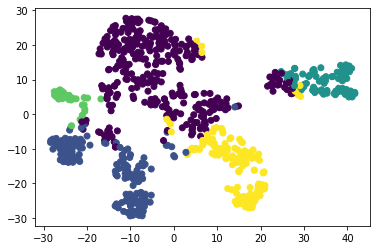

In [28]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



# Ajustar el modelo KMeans
kmeans = KMeans(n_clusters=5) # Elige el número de clusters que desees
kmeans.fit(doc_vectors)

# Obtener las etiquetas de cluster para cada documento
labels = kmeans.labels_

# Reducir la dimensionalidad de los vectores de características utilizando t-SNE
tsne = TSNE(n_components=2)
reduced_vectors = tsne.fit_transform(doc_vectors)

# Visualizar los resultados
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=labels, cmap='viridis')
plt.show()


Utilizamos para agrupar los documentos el algoritmo de clustering jerárquico aglomerativo y visualizamos los resultados utilizando un dendrograma

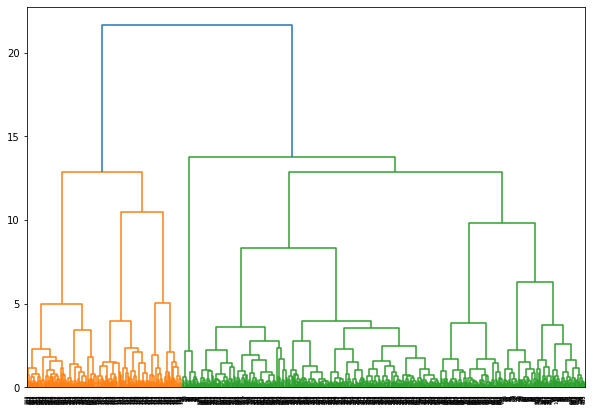

In [32]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Ajustar el modelo de clustering jerárquico aglomerativo
Z = linkage(doc_vectors, 'ward')

# Visualizar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.show()


Hay varios métodos de enlace disponibles, incluyendo 'ward', 'single', 'complete', 'average' y 'centroid'. Cada método utiliza una fórmula diferente para calcular las distancias entre los clusters y puede producir resultados diferentes.

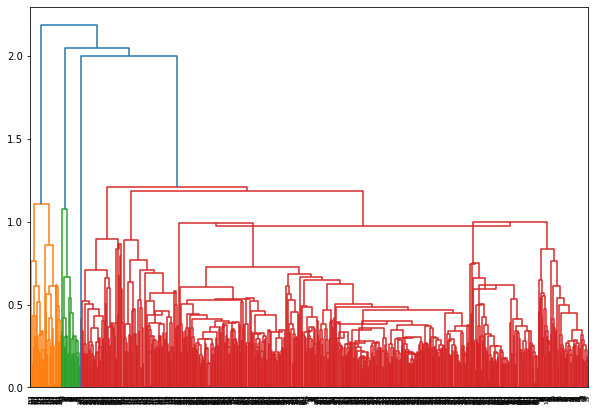

In [36]:
# Ajustar el modelo de clustering jerárquico aglomerativo utilizando el método de enlace 'complete'
Z = linkage(doc_vectors, 'centroid')

# Visualizar el dendrograma
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.show()


Este código corta el dendrograma en un nivel específico (definido por la variable max_d) y asigna una etiqueta de cluster a cada documento. Luego, visualiza los resultados en un gráfico de dispersión utilizando los vectores reducidos obtenidos con t-SNE. La función fcluster del módulo scipy.cluster.hierarchy corta el dendrograma en un nivel específico y obtiene las etiquetas de cluster para cada documento

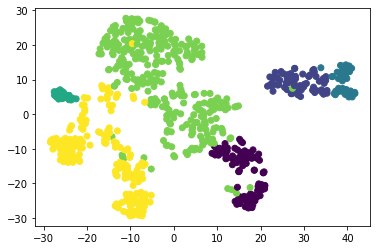

In [31]:
from scipy.cluster.hierarchy import fcluster

# Cortar el dendrograma en un nivel específico para obtener las etiquetas de cluster
max_d = 10 #Elige el valor que desees
labels = fcluster(Z, max_d, criterion='distance')

# Visualizar los resultados
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=labels, cmap='viridis')
plt.show()
